In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.models import Model
from keras.layers import *
from keras.activations import *

In [0]:
def get_gru_last_step(lstm_sequences):
    return Lambda(lambda sequence: sequence[:, -1, :])(lstm_sequences)

def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

gru_options = {
    'units': 128,
    'dropout': 0.2,
    'return_sequences': True
}

In [11]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()(
    [pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(averaged_embedding_layer)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

pooled_features = Dropout(0.2)(pooled_features)

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21440/102124 [=====>........................] - ETA: 5:46 - loss: 0.1097 - acc: 0.9631

102112/102124 [============================>.] - ETA: 0s - loss: 0.0701 - acc: 0.9756

102124/102124 [==============================] - 461s 5ms/step - loss: 0.0701 - acc: 0.9756 - val_loss: 0.0459 - val_acc: 0.9825
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 6:06 - loss: 0.0534 - acc: 0.9800

102112/102124 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9807

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0515 - acc: 0.9807 - val_loss: 0.0454 - val_acc: 0.9830
roc-auc: 0.9873 - roc-auc_val: 0.9836                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 6:27 - loss: 0.0471 - acc: 0.9816

102112/102124 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9818

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0474 - acc: 0.9818 - val_loss: 0.0437 - val_acc: 0.9834
Epoch 4/32
 10176/102124 [=>............................] - ETA: 6:20 - loss: 0.0437 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9828

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0450 - acc: 0.9828 - val_loss: 0.0441 - val_acc: 0.9839
roc-auc: 0.991 - roc-auc_val: 0.9875                                                                                                    
Epoch 5/32
  8768/102124 [=>............................] - ETA: 6:27 - loss: 0.0414 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9831

102124/102124 [==============================] - 458s 4ms/step - loss: 0.0435 - acc: 0.9831 - val_loss: 0.0449 - val_acc: 0.9835

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003298769879620522.
Epoch 6/32
  8064/102124 [=>............................] - ETA: 6:29 - loss: 0.0422 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9835

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0419 - acc: 0.9835 - val_loss: 0.0455 - val_acc: 0.9835
roc-auc: 0.9926 - roc-auc_val: 0.9885                                                                                                    
Epoch 7/32
  8736/102124 [=>............................] - ETA: 6:28 - loss: 0.0399 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9841

102124/102124 [==============================] - 458s 4ms/step - loss: 0.0407 - acc: 0.9841 - val_loss: 0.0411 - val_acc: 0.9843
Epoch 8/32
 10176/102124 [=>............................] - ETA: 6:20 - loss: 0.0377 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9845

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0396 - acc: 0.9845 - val_loss: 0.0449 - val_acc: 0.9835
roc-auc: 0.9935 - roc-auc_val: 0.9883                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 6:27 - loss: 0.0377 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9848

102124/102124 [==============================] - 455s 4ms/step - loss: 0.0387 - acc: 0.9848 - val_loss: 0.0446 - val_acc: 0.9838
Epoch 10/32
 10144/102124 [=>............................] - ETA: 6:22 - loss: 0.0369 - acc: 0.9855

102112/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9851

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0379 - acc: 0.9851 - val_loss: 0.0433 - val_acc: 0.9843
roc-auc: 0.994 - roc-auc_val: 0.9879                                                                                                    
Epoch 11/32
  8736/102124 [=>............................] - ETA: 6:27 - loss: 0.0394 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9855

102124/102124 [==============================] - 458s 4ms/step - loss: 0.0369 - acc: 0.9855 - val_loss: 0.0433 - val_acc: 0.9845
Epoch 12/32
 10144/102124 [=>............................] - ETA: 6:21 - loss: 0.0356 - acc: 0.9863

102112/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9855

102124/102124 [==============================] - 458s 4ms/step - loss: 0.0365 - acc: 0.9855 - val_loss: 0.0439 - val_acc: 0.9842
roc-auc: 0.9951 - roc-auc_val: 0.9883                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 6:26 - loss: 0.0356 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9859

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0354 - acc: 0.9859 - val_loss: 0.0438 - val_acc: 0.9843
Epoch 14/32
 10144/102124 [=>............................] - ETA: 6:22 - loss: 0.0341 - acc: 0.9863

102112/102124 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9863

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0346 - acc: 0.9863 - val_loss: 0.0448 - val_acc: 0.9843
roc-auc: 0.9954 - roc-auc_val: 0.9882                                                                                                    
Epoch 15/32
  8704/102124 [=>............................] - ETA: 6:28 - loss: 0.0336 - acc: 0.9862

102112/102124 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9864

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0341 - acc: 0.9864 - val_loss: 0.0435 - val_acc: 0.9848
Epoch 16/32
 10144/102124 [=>............................] - ETA: 6:22 - loss: 0.0340 - acc: 0.9864

102112/102124 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9866

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0336 - acc: 0.9866 - val_loss: 0.0442 - val_acc: 0.9845

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010511204891372472.
roc-auc: 0.9958 - roc-auc_val: 0.9877                                                                                                    
Epoch 17/32
  5952/102124 [>.............................] - ETA: 6:37 - loss: 0.0323 - acc: 0.9876

102112/102124 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9869

102124/102124 [==============================] - 457s 4ms/step - loss: 0.0332 - acc: 0.9869 - val_loss: 0.0424 - val_acc: 0.9846


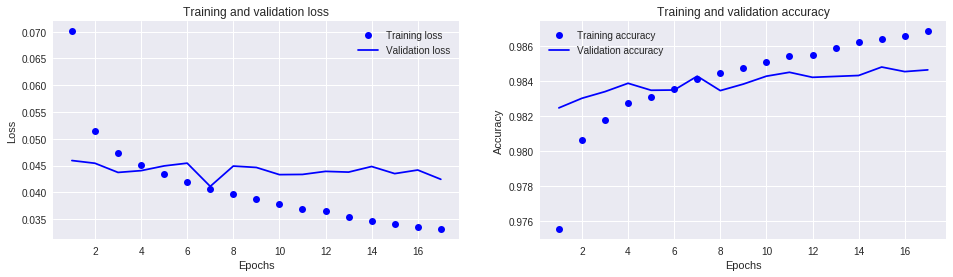

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 43s 1ms/step
([0.0407612808887324, 0.9851898133241138], 0.9898879224821987)
